# Household Electric Power Consumption

Method used: RandomForestRegressor.

### By Pratham Shah (B.Tech CSE, 240905614, 2028) for the Cryptonite Research Taskphase

## Imports and Loading the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, na_values=['nan','?'])
df = df.copy()

/tmp/ipykernel_90770/199733144.py:8: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, na_values=['nan','?'])
/tmp/ipykernel_90770/199733144.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, na_values=['nan','?'])
/tmp/ipykernel_90770/199733144.py:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a for

# EDA

In [2]:
print("DATA INFORMATION:")
print(df.info())
print("\n\nDATA DESCRIPTION")
print(df.describe())

DATA INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date_time              datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
None


DATA DESCRIPTION
                           date_time  Global_active_power  \
count                        2075259         2.049280e+06   
mean   2008-12-06 07:12:59.999994112         1.091615e+00   
min              2006-12-16 17:24:00         7.600000e-02   
25%              2007-12-12 00:18:30         3.080000e-01   
50%              2008-12-06 07:13:00         6.020

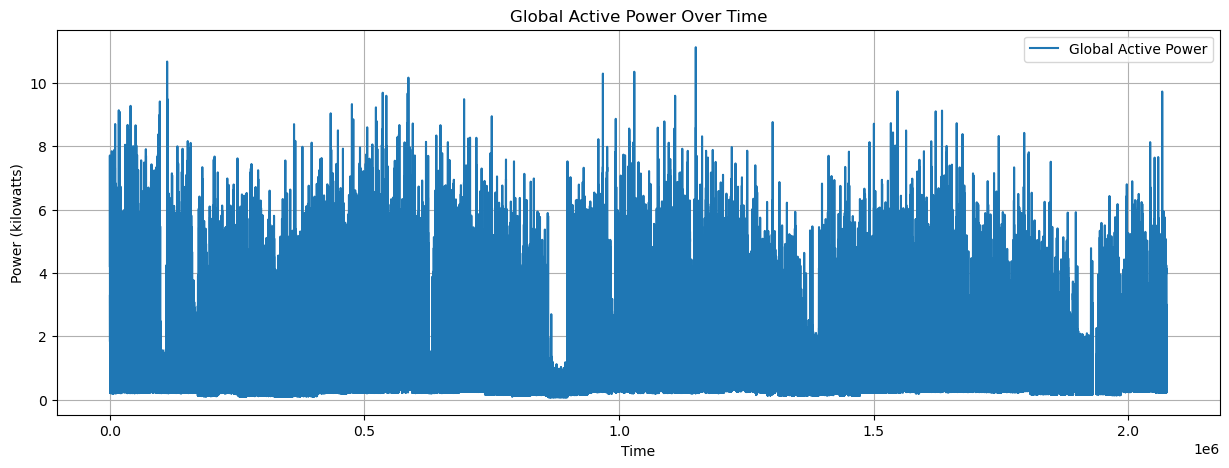

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(df['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.ylabel('Power (kilowatts)')
plt.xlabel('Time')
plt.grid(True)
plt.legend()
plt.show()

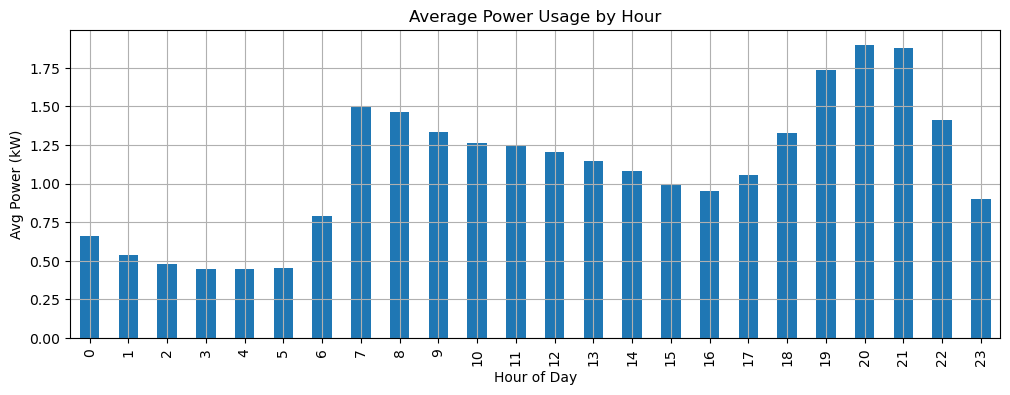

In [4]:
df_temp = df.copy()
hourly_avg = df_temp.groupby(df_temp["date_time"].dt.hour)['Global_active_power'].mean()

plt.figure(figsize=(12, 4))
hourly_avg.plot(kind='bar')
plt.title('Average Power Usage by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Power (kW)')
plt.grid(True)
plt.show()


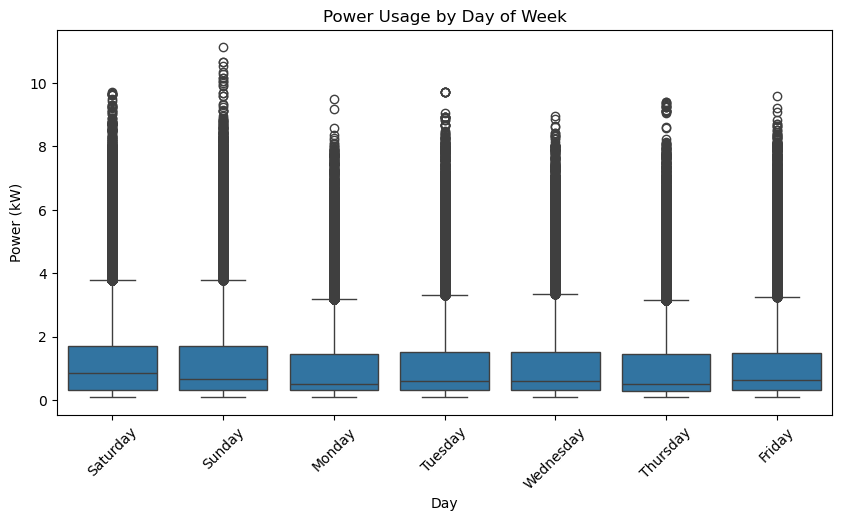

In [5]:
df_temp['day_name'] = df_temp["date_time"].dt.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x='day_name', y='Global_active_power', data=df_temp)
plt.xlabel("Day")
plt.ylabel("Power (kW)")
plt.title('Power Usage by Day of Week')
plt.xticks(rotation=45)
plt.show()

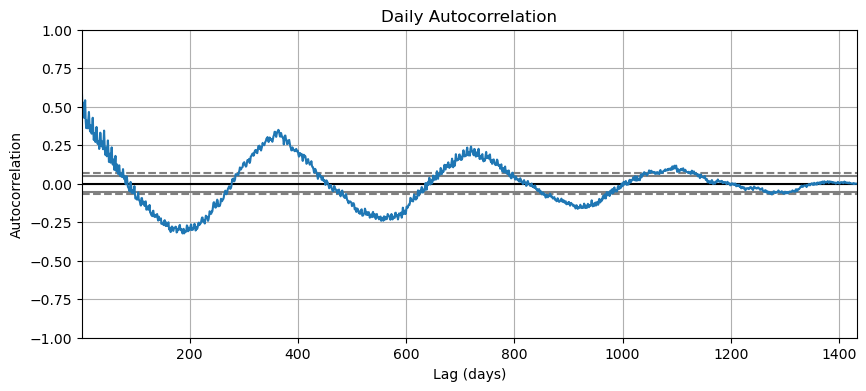

In [6]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

df_temp.set_index('date_time', inplace=True)
df_daily = df_temp['Global_active_power'].resample('D').mean()

plt.figure(figsize=(10, 4))
autocorrelation_plot(df_daily.dropna())
plt.title('Daily Autocorrelation')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


## Feature Engineering

In [7]:
df['year'] = df['date_time'].dt.year
df['quarter'] = df['date_time'].dt.quarter
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour_of_day'] = df['date_time'].dt.hour #creating new columns to better capture time dependencies
df['is_weekend'] = df['date_time'].dt.dayofweek >= 5
df['is_weekend'] = df['is_weekend'].astype(int)  #weekend : 1, weekday : 0. idea is that weekend signifies greater consumption

# Lag features
for lag in [1, 30, 60, 1440]:
    df[f'lag_{lag}_min'] = df['Global_active_power'].shift(lag)

# Rolling statistics
df['rolling_mean_60'] = df['Global_active_power'].rolling(window=60).mean()
df['rolling_std_60'] = df['Global_active_power'].rolling(window=60).std()
    
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

df.dropna(inplace=True) #drop all null/nan values introduced by rolling lag and within the dataset

df

,date_time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,year,quarter,month,day,hour_of_day,is_weekend,lag_1_min,lag_30_min,lag_60_min,lag_1440_min,rolling_mean_60,rolling_std_60
1440,2006-12-17 17:24:00,3.390,0.170,232.65,14.6,0.0,0.0,17.0,2006,4,12,17,17,1,3.238,3.328,4.864,4.216,3.527967,0.671762
1441,2006-12-17 17:25:00,3.360,0.164,231.20,14.4,0.0,0.0,16.0,2006,4,12,17,17,1,3.390,3.316,4.868,5.360,3.502833,0.648586
1442,2006-12-17 17:26:00,3.400,0.162,232.86,14.6,0.0,0.0,17.0,2006,4,12,17,17,1,3.360,3.390,4.876,5.374,3.478233,0.623112
1443,2006-12-17 17:27:00,3.396,0.164,232.89,14.6,0.0,0.0,17.0,2006,4,12,17,17,1,3.400,3.418,4.810,5.388,3.454667,0.598129
1444,2006-12-17 17:28:00,3.282,0.100,232.33,14.0,0.0,0.0,16.0,2006,4,12,17,17,1,3.396,3.384,4.790,3.666,3.429533,0.572188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010,4,11,26,20,0,0.946,0.982,1.526,1.522,1.173367,0.312391
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010,4,11,26,20,0,0.946,0.958,1.524,1.518,1.163700,0.310324
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010,4,11,26,21,0,0.944,0.980,1.456,1.512,1.155067,0.309258
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010,4,11,26,21,0,0.938,0.982,1.554,1.508,1.144733,0.306044


In [8]:
df.drop(["Global_intensity", "date_time"], axis=1, inplace=True)

print('Number of rows and columns:', df.shape)

Number of rows and columns: (2034118, 18)


## Preparation for the Model

In [9]:
target_col = 'Global_active_power'
features = df.drop(columns=[target_col])
target = df[target_col] #split target and x

split_index = int(len(df) * 0.8) #0.8 split of train and test data

X_train_raw, X_test_raw = features[:split_index], features[split_index:]
y_train_raw, y_test_raw = target[:split_index], target[split_index:]

feature_scaler = StandardScaler()
X_train = pd.DataFrame(
    feature_scaler.fit_transform(X_train_raw),
    columns=X_train_raw.columns,
    index=X_train_raw.index
)
X_test = pd.DataFrame(
    feature_scaler.transform(X_test_raw),
    columns=X_test_raw.columns,
    index=X_test_raw.index
)

target_scaler = StandardScaler() #different scaler for target - needed to invert
y_train = target_scaler.fit_transform(y_train_raw.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test_raw.values.reshape(-1, 1))

## The Model

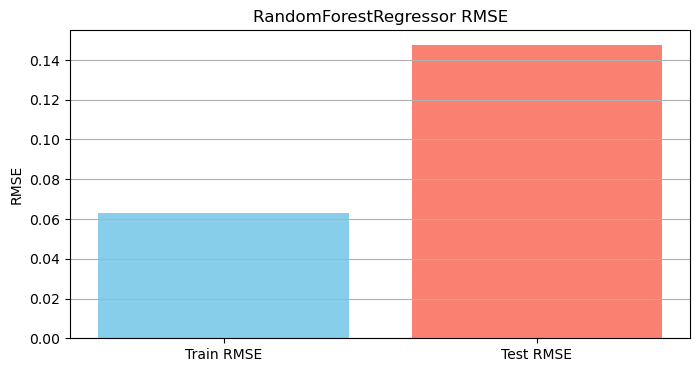

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train.ravel())

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

plt.figure(figsize=(8, 4))
plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse, test_rmse], color=['skyblue', 'salmon'])
plt.title('RandomForestRegressor RMSE')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()


## Predictions Evaluation

In [11]:
train_predict = model.predict(X_train).reshape(-1, 1)
test_predict = model.predict(X_test).reshape(-1, 1)

train_predict_inv = target_scaler.inverse_transform(train_predict)
test_predict_inv = target_scaler.inverse_transform(test_predict)

y_train_inv = target_scaler.inverse_transform(y_train)
y_test_inv = target_scaler.inverse_transform(y_test)

print('Train Mean Absolute Error:', mean_absolute_error(y_train_inv, train_predict_inv))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train_inv, train_predict_inv)))
print('Train R2 score:', r2_score(y_train_inv, train_predict_inv))

print('Test Mean Absolute Error:', mean_absolute_error(y_test_inv, test_predict_inv))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_inv, test_predict_inv)))
print('Test R2 score:', r2_score(y_test_inv, test_predict_inv))


Train Mean Absolute Error: 0.023577823601635548
Train Root Mean Squared Error: 0.06885019096662215
Train R2 score: 0.9960216412566333
Test Mean Absolute Error: 0.06799912601026481
Test Root Mean Squared Error: 0.16106030794972293
Test R2 score: 0.9677712418293004


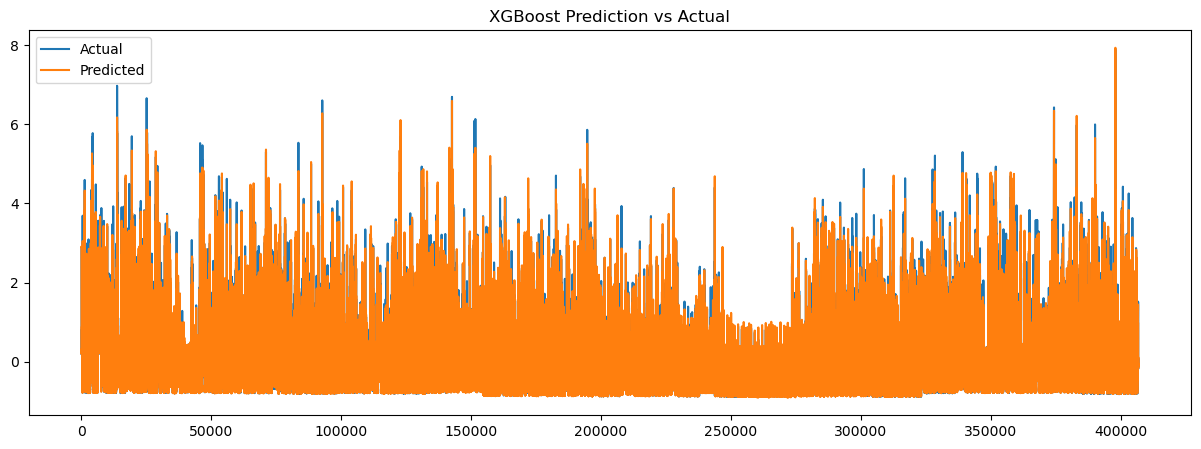

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('XGBoost Prediction vs Actual')
plt.legend()
plt.show()

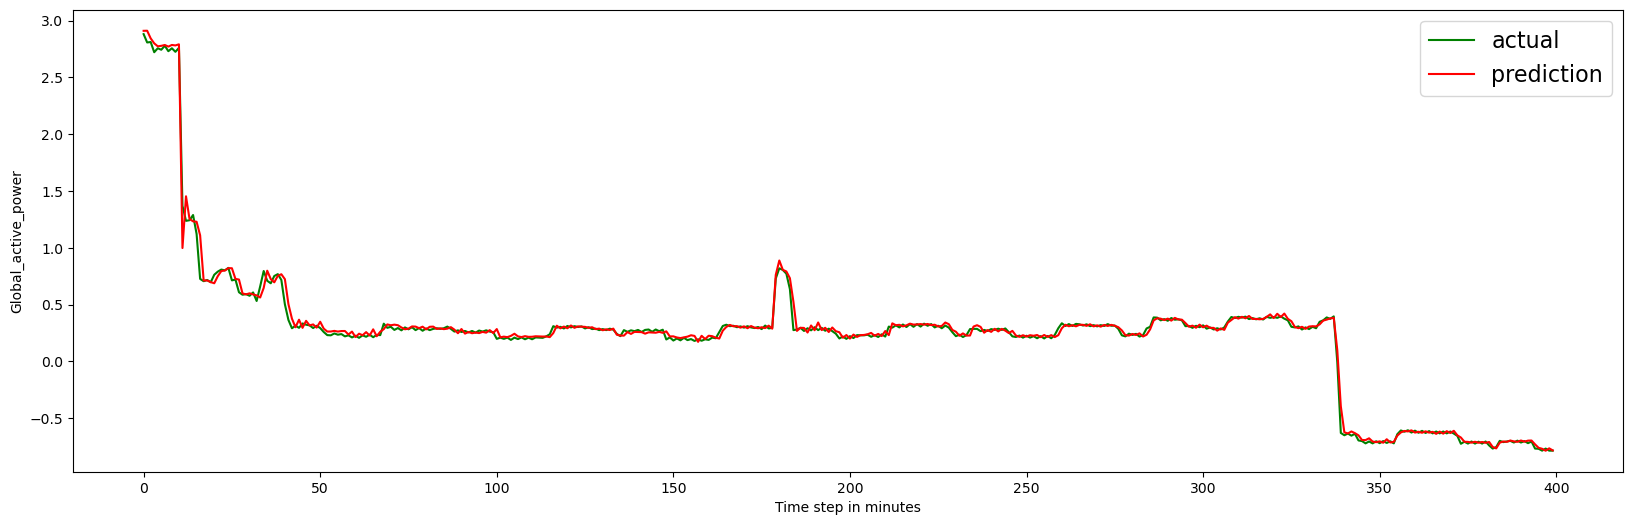

In [13]:
indice = 400 #number of testing examples to use

limit = [x for x in range(indice)]
plt.figure(figsize=(20,6))

plt.plot(limit, y_test[:indice], label="actual", color='green')
plt.plot(limit, test_predict[:,0][:indice], '-', label="prediction", color='red')

plt.ylabel('Global_active_power')
plt.xlabel('Time step in minutes')
plt.legend(fontsize=16)

plt.show()


## Evaluation Across a Time Series Split:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

timecrossval = TimeSeriesSplit(n_splits=3)

scores = cross_val_score(model, np.concatenate([X_train, X_test], axis=0), np.concatenate([y_train, y_test], axis=0).ravel(), cv=timecrossval, scoring='r2')

print("R2 scores for all folds: ", scores)
print("Mean R2 score: ", scores.mean())

## Conclusion:

The model is predicting the electric power usage in a time-series bound way and is returning efficient results.